In [6]:
import pandas as pd

from math import ceil
import numpy as np
from matplotlib import pyplot as plt


from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.data_generator import DataGenerator
from data_generator.data_augmentation import DataAugmentation


%matplotlib inline

In [2]:
train = open("wider_data/wider_face_train_bbx_gt.txt")
val   = open("wider_data/wider_face_val_bbx_gt.txt" ) 

data=[train,val]
csv_names=["train","val"]
for s in range(2):
    
    f=data[s]
    c_name=csv_names[s]
    
    x_mins=[]
    y_mins=[]
    x_maxs=[]
    y_maxs=[]
    face_names=[]
    classes=[]

    while True:
        name=f.readline().rstrip()
        if len(name)==0:
            print("reading  is done ")
            break

        face_num=f.readline().rstrip()


        for i in range(int(face_num)):
            anot=f.readline().rstrip().split()
            face_names.append(name)
            x_mins.append(float(anot[0]))
            y_mins.append(float(anot[1]))
            x_maxs.append(float(anot[0])+float(anot[2]))
            y_maxs.append(float(anot[1])+float(anot[3]))
            classes.append(1)
    frame=pd.DataFrame({"image_name":face_names,"xmin":x_mins,"xmax":x_maxs,"ymin":y_mins,"ymax":y_maxs,"class_id":classes})
    frame.to_excel("wider_data/"+c_name+".xlsx",index=False)
    df=pd.read_excel("wider_data/"+c_name+".xlsx")
    df.to_csv("wider_data/"+c_name+".csv",index=False)

reading  is done 
reading  is done 


In [5]:
data=pd.read_csv("wider_data/val.csv")
data.head()

,image_name,xmin,xmax,ymin,ymax,class_id
0,0--Parade/0_Parade_marchingband_1_465.jpg,345,349,211,215,1
1,0--Parade/0_Parade_marchingband_1_465.jpg,331,334,126,129,1
2,0--Parade/0_Parade_marchingband_1_465.jpg,250,253,126,130,1
3,0--Parade/0_Parade_marchingband_1_465.jpg,221,225,128,133,1
4,0--Parade/0_Parade_marchingband_1_465.jpg,427,430,116,120,1


In [12]:
img_height = 400 # Height of the input images
img_width = 400 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 1 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [34]:
dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

images_dir = 'wider_data/WIDER_val/images/'
labels_filename="wider_data/val.csv"
dataset.parse_csv(images_dir=images_dir,
                        labels_filename=labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

dataset_size = dataset.get_dataset_size()


print("Number of images in the training dataset:\t{:>6}".format(dataset_size))



Number of images in the training dataset:	  3226
Creating HDF5 dataset: 100%|██████████| 3226/3226 [04:34<00:00, 11.75it/s]


In [23]:

# Set the batch size.

batch_size = 6

# Define the image processing chain.

data_augmentation_chain = DataAugmentation(resize=True,
                                            img_height=400,
                                            img_width=400,
                                            random_brightness=(-48, 48, 0.5),
                                            random_contrast=(0.5, 1.8, 0.5),
                                            random_saturation=(0.5, 1.8, 0.5),
                                            random_hue=(18, 0.5),
                                            random_flip=0.5,
                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                            random_scale=(0.5, 2.0, 0.5),
                                            n_trials_max=3,
                                            clip_boxes=True,
                                            overlap_criterion='area',
                                            bounds_box_filter=(0.3, 1.0),
                                            bounds_validator=(0.5, 1.0),
                                            n_boxes_min=1,
                                            background=(0,0,0))


"""
Returns:
    `y_encoded`, a 3D numpy array of shape `(batch_size, #boxes, #classes + 4 + 4 + 4)` that serves as the
    ground truth label tensor for training, where `#boxes` is the total number of boxes predicted by the
    model per image, and the classes are one-hot-encoded. The four elements after the class vecotrs in
    the last axis are the box coordinates, the next four elements after that are just dummy elements, and
    the last four elements are the variances.
    
"""

generator = dataset.generate(batch_size=batch_size,
                             shuffle=False,
                             transformations=[data_augmentation_chain],
                             label_encoder=None,
                             returns={'processed_images'},
                             keep_images_without_gt=False)

        

In [32]:
images=next(generator)
images[0].shape

(6, 400, 400, 3)

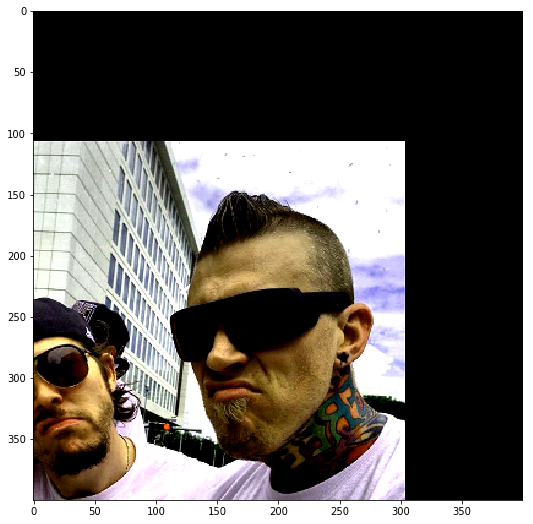

In [33]:
plt.figure(figsize=(9,9))
plt.imshow(images[0][1])
